In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import annotations
from typing import Any, Callable, List, Optional, Tuple

import os
import sys
sys.path.append("../") # So we can use the coordination package

import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns

from coordination.model.synthetic.conversation import ConversationModel
from coordination.model.synthetic.spring import SpringModel
from coordination.model.config_bundle.conversation import ConversationConfigBundle
from coordination.model.config_bundle.spring import SpringConfigBundle
from coordination.module.coordination.sigmoid_gaussian_coordination import SigmoidGaussianCoordinationSamples
from coordination.module.observation.observation import ObservationSamples
from coordination.module.module import ModuleSamples
from coordination.inference.inference_data import InferenceData

# Helper functions

In [3]:
def calculate_best_figure_dimensions(document_width: Union[str, float], scale=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    document_width: Union[str, float]
            Document textwidth or columnwidth in pts. Predefined strings are also acceptable.
    scale: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = document_width

    # Width of figure (in pts)
    fig_width_pt = width_pt * scale

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in

def custom_formatter(x, pos):
    result = x
    if result == 0:
        return '0'
    # If not 0, format as multiples of 1000 (1K, 2K, 3K, etc.)
    return f'{result/1000:.1f}K'

def save_plot(image_name: str, fig: Any, format: str = "pdf"):
    if SAVE:
        fig.savefig(f"../assets/images/{image_name}.{format}", format=format, bbox_inches='tight', pad_inches=0)

def plot_conversation_data(ax: Any, data: ObservationSamples, title: str = "", line_width: float = 1, y_shift_fn: Callable = lambda x,s: x):
    for s, name in enumerate(SUBJECT_NAMES):
        tt = np.array([t for t, subject in enumerate(data.subject_indices[0]) if s == subject])
        ax.plot(tt, y_shift_fn(data.values[0][0, tt],s), label=name, color=COLORS_CONV[s], linewidth=line_width, linestyle='solid')
    sns.despine(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position") 

def plot_spring_data(ax: Any, data: ObservationSamples, title: str = "", line_width: float = 1, y_shift_fn: Callable = lambda x,s: x):
    num_springs = data.values[0].shape[0]
    num_time_steps = data.values[0].shape[-1]
    
    tt = np.arange(num_time_steps)
    
    for s in range(num_springs):        
        ax.plot(tt, y_shift_fn(data.values[0][s, 0],s), label=f"Spring {s + 1}", color=COLORS_SPR[s], linewidth=line_width, linestyle='solid')
        
    sns.despine(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position") 

# Style

In [4]:
sns.set_style("white")
tex_fonts = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.titlesize": 8,
    "axes.linewidth": 1
}
plt.rcParams.update(tex_fonts)
plt.rc('pdf',fonttype = 42)
plt.rcParams['text.usetex'] = True

DOC_WIDTH = 400

# Constants

In [6]:
# Plot
SAVE = False
COLORS_SPR = ["#137513", "#FF9090", "#13B2FF"]
COLORS_CONV = ["#13B2FF", "#FF9090", "#137513"]
MUSTARD = "#BE9700"
SUBJECT_NAMES=["Bob", "Alice", "Dan"]

# Reproducibility
SEED = 0

# Data 
T=100

# Inference
BURN_IN = 2000
NUM_SAMPLES = 2000
NUM_CHAINS = 4
TARGET_ACCEPT = 0.9

# Conversation Model

Simulates a hypothetical dialog among three individuals: Bob, Alice, and Dan. Their voices intensify with excitement, reaching a point of embarrassment, and then they gradually lower their voices. Without coordination, Bob, Alice, and Dan’s vocal intensities follow their own rhythms. Coordination indicates the extent to which their speech styles influence each other.

## Synthetic Data

Below synthetic data is generated without noise for better visualization.

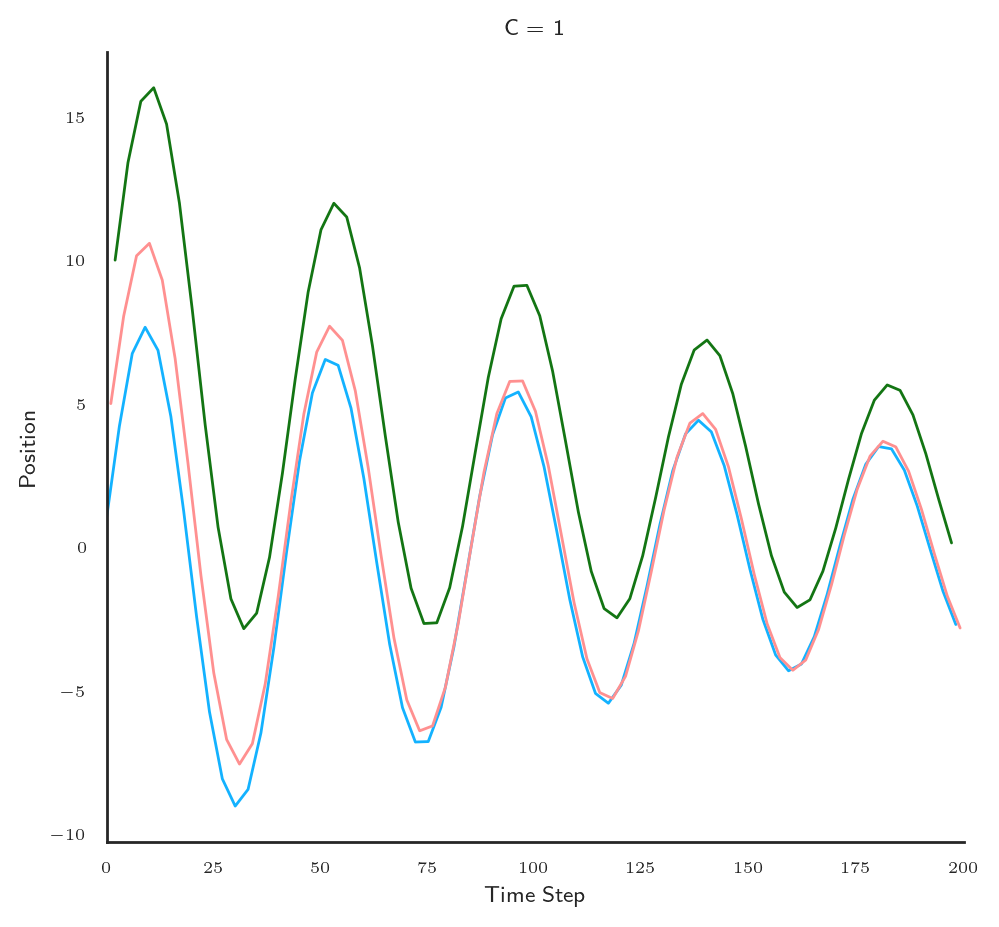

In [70]:
T_Plot = 200
config_bundle = ConversationConfigBundle()
config_bundle.sd_a = 0.  # only for plots
config_bundle.sd_o = 0.
config_bundle.num_time_steps_in_coordination_scale = T_Plot
config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)))
# config_bundle.squared_angular_frequency = 1
config_bundle.mean_a0 = np.array([[1, 6], [5, 6], [10, 6]])
config_bundle.blend_position = False
config_bundle.blend_speed = True
model = ConversationModel(config_bundle)

model.prepare_for_sampling()
data = model.draw_samples(seed=SEED).component_group_samples["observation"]

# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1)  
fig = plt.figure(figsize=(w,h*1.5))
x_slice = [0, T_Plot]
plot_conversation_data(fig.gca(), data, title=f"C = 1", line_width=1)
_ = plt.xlim(x_slice)

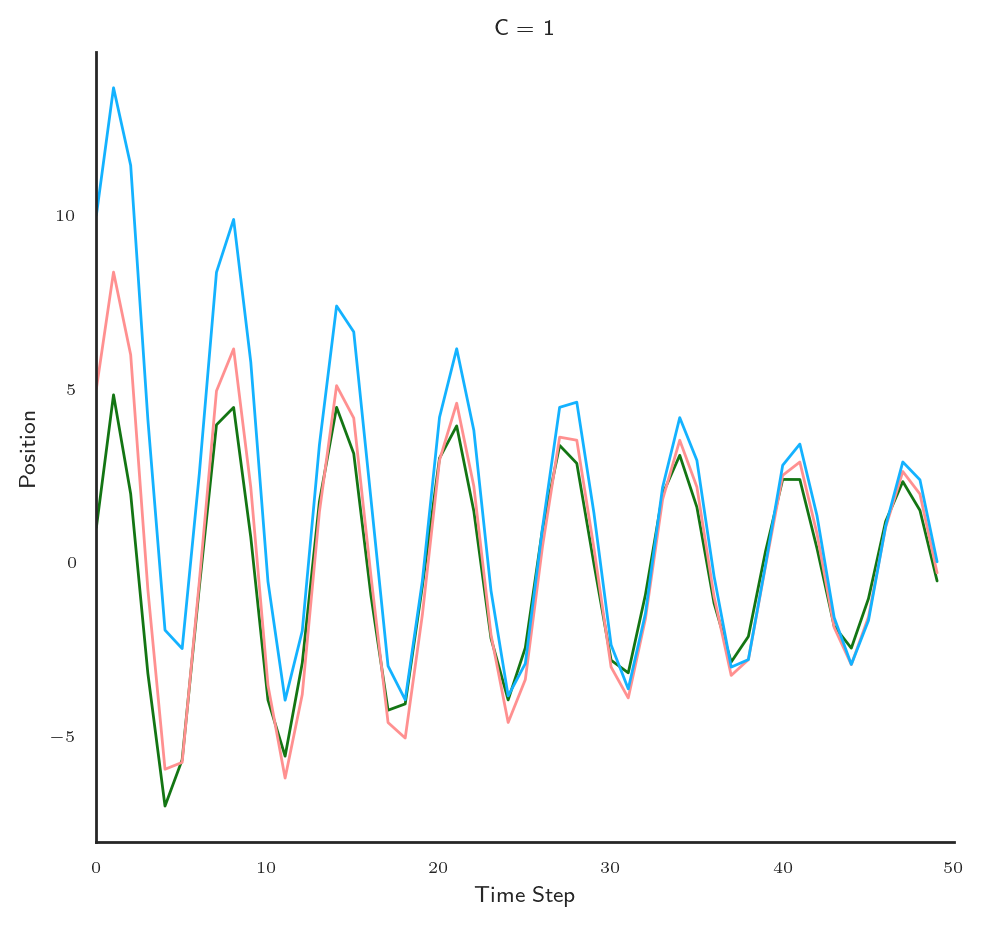

In [71]:
T_Plot = 50
config_bundle = SpringConfigBundle()
config_bundle.sd_a = 0.  # only for plots
config_bundle.sd_o = 0.
config_bundle.num_time_steps_in_coordination_scale = T_Plot
config_bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=np.ones((1, T_Plot)))
# config_bundle.spring_constant = 8
config_bundle.mean_a0 = np.array([[1, 6], [5, 6], [10, 6]])
config_bundle.blend_position = False
config_bundle.blend_speed = True
# config_bundle.time_step_size_in_seconds = 0.2
model = SpringModel(config_bundle)

model.prepare_for_sampling()
data = model.draw_samples(seed=SEED).component_group_samples["observation"]

# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC_WIDTH, scale=1)  
fig = plt.figure(figsize=(w,h*1.5))
x_slice = [0, T_Plot]
plot_spring_data(fig.gca(), data, title=f"C = 1", line_width=1)
_ = plt.xlim(x_slice)